In [1]:
# import libraries
from cil.optimisation.algorithms import SIRT, CGLS
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.utilities.display import show2D

import numpy as np
import os, sys

import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 12 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.1, voxel_size_y = 0.1)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry
detectors =  N
angles = np.linspace(0, 180, 180, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

# inverse crime
sino = A.direct(phantom2D)

# no inverse crime
# sino_analytic = TomoP2D.ModelSino(model, N, detectors, angles, path_library2D)

noisy_data = ag.allocate()
noisy_data.fill(sino + np.random.normal(0, 0.5, ag.shape))

In [7]:
# Simple Backprojection
bp = A.adjoint(noisy_data)

In [8]:
# FBP reconstruction
fbp = FBP(ig, ag)(noisy_data)

In [9]:
# Setup and run SIRT reconstruction
sirt = SIRT(initial=ig.allocate(), operator = A, data = noisy_data, 
            max_iteration=100, update_objective_interval=10)
sirt.run(100, verbose=1)

SIRT setting up
SIRT configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          2.07316e+06
       10        100         0.016          5.29080e+04
       20        100         0.015          2.96828e+04
       30        100         0.015          2.04655e+04
       40        100         0.015          1.57791e+04
       50        100         0.015          1.30570e+04
       60        100         0.015          1.13118e+04
       70        100         0.014          1.01024e+04
       80        100         0.014          9.21109e+03
       90        100         0.014          8.52144e+03
      100        100         0.014          7.96716e+03
-------------------------------------------------------
      100        100         0.014          7.96716e+03
Stop criterion has been reached.



In [10]:
# Setup and run CGLS reconstruction
cgls = CGLS(initial=ig.allocate(), operator = A, data = noisy_data, 
            max_iteration=100, update_objective_interval=5)
cgls.run(20, verbose=1)

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          2.07316e+06
        5        100         0.044          1.48487e+04
       10        100         0.046          7.04094e+03
       15        100         0.045          4.28915e+03
       20        100         0.044          3.48667e+03
-------------------------------------------------------
       20        100         0.044          3.48667e+03
Stop criterion has been reached.



/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/utilities/display.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


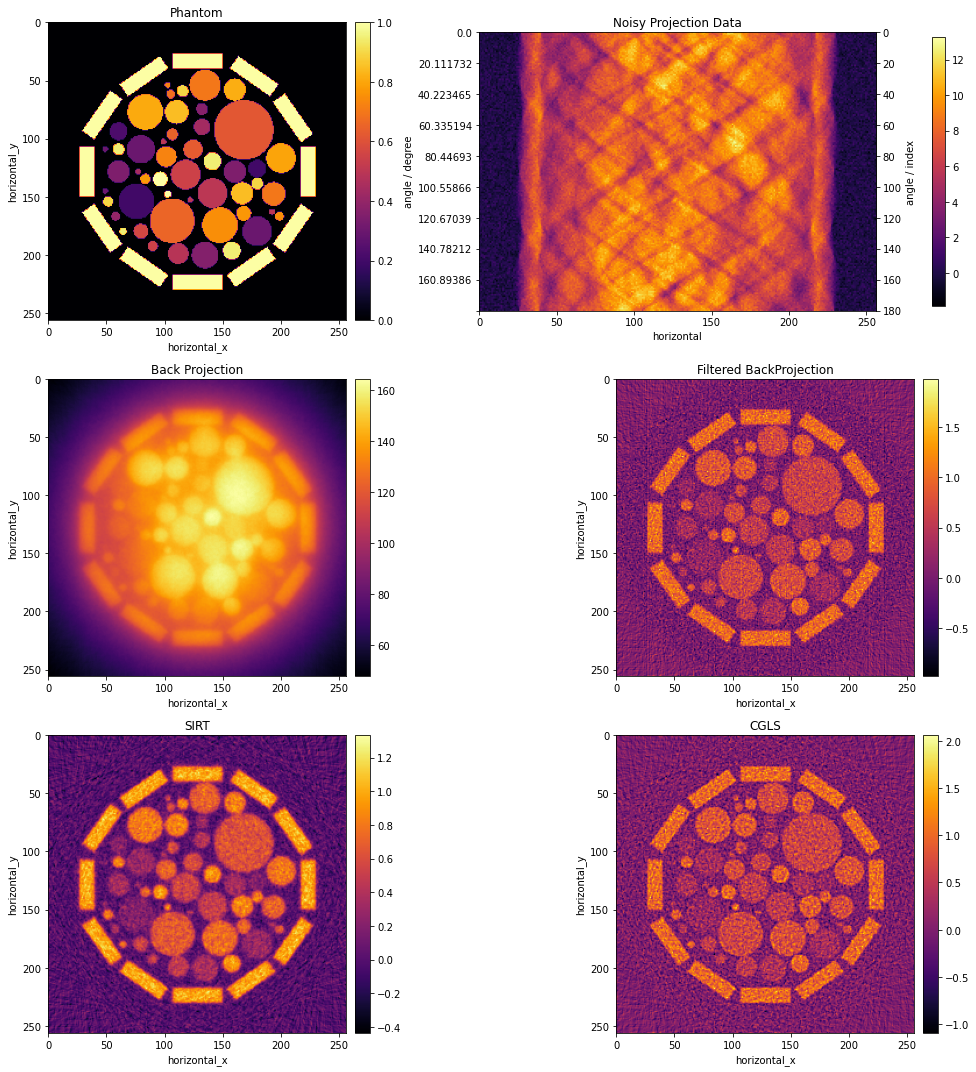

In [11]:
show2D([phantom2D, noisy_data, bp, fbp, sirt.solution, cgls.solution],
          title=["Phantom", "Noisy Projection Data", "Back Projection", "Filtered BackProjection", "SIRT", "CGLS"],
         origin = "upper", cmap="inferno")